**Generator tesktów piosenek**



Import bibliiotek

In [1]:
from pylab import imshow, show
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from nltk import flatten
import string, os, nltk, re, keras, io,sys, time,pickle,warnings
from tensorflow.keras import layers
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Activation, Embedding, Flatten
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.optimizers import Adamax
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
import datetime
import csv
from keras.utils import np_utils
import plotly.graph_objects as go
warnings.filterwarnings("ignore")

Import danych ze strony:
 https://marianaossilva.github.io/DSW2019/index.html

In [2]:
artists=pd.read_csv('dataset/raw_data/artists.csv',   delimiter="\t", usecols = ['genres','artist_id'])
songs=pd.read_csv('dataset/raw_data/songs.csv',  delimiter="\t",  usecols = ['artists','song_id'])
lyrics=pd.read_csv('dataset/raw_data/lyrics.csv',  delimiter="\t",  usecols = ['song_id','lyrics'], quoting=csv.QUOTE_NONE).dropna(how='any')

In [3]:
genres=['pop', 'rock', 'jazz', 'rap', 'country', 'blues']

for genre in genres:
  globals()[f'{genre}']=[]
  for l in artists['genres']:
    if genre in l:
      globals()[f'{genre}'].append('yes')
    else:
      globals()[f'{genre}'].append('')

  artists[genre]=globals()[f'{genre}']

In [4]:
songs['artists'] = songs['artists'].map(lambda x: x.split("""'""")[1])
artists=artists.merge(songs, left_on='artist_id', right_on='artists')
lyrics=artists.merge(lyrics, left_on='song_id', right_on='song_id')
df=lyrics.loc[:, ['pop','rock','jazz','rap','country','blues', 'lyrics']]
df.head()

,pop,rock,jazz,rap,country,blues,lyrics
0,yes,,,,,,"""['[Verse 1]\nThought I\'d end up with Sean\nB..."
1,yes,,,,,,"""[""""[Intro]\nLacigam gnihtemos od ot\nThgin la..."
2,yes,,,,,,"""['[Verse 1]\nStep up, the two of us, nobody k..."
3,yes,,,,,,"""[""""[Chorus]\nYou, you love it how I move you\..."
4,yes,,,,,,"""[""""[Intro]\nRight now, I'm in a state of mind..."


**PRE PROCESSING**

Zatrzymanie tylko podstawowych znaków.

Zatrzymane zostały także znaki zmiany linijki, aby piosenka miała podział.

In [5]:
def extract_text(x):
    lyrics_new = []
    df_2 = {}

    chunks = x['lyrics'].split('\\n\\n')
    words = {'Intro':np.empty, 'Chorus':np.empty, 'Verse 1': np.empty,'Verse 2':np.empty,'Verse 3':np.empty,'Verse 4':np.empty,'Verse 5':np.empty}

    for c in chunks:
        part = c[c.find('[') + 1:c.find(']')].strip()
        if part in words:
            lyrics_new += [x.translate(str.maketrans('', '', string.punctuation)) for x in c[c.find(']')+1:].split('\\n') if len(x) > 1]
        df_2['lyrics_new'] =  ' \n '.join(lyrics_new)
    return pd.Series(df_2)

df = df.join( df.apply(extract_text, axis=1))
df['lyrics_new'] = df['lyrics_new'].apply(lambda x: ' \n '.join([l.lower().strip().translate(str.maketrans('', '', string.punctuation)) for l in x.splitlines() if len(l)>0]))

def remove_chars(s):
    return re.sub(r'\\x..', '', s)

df['lyrics_new']=df['lyrics_new'].apply(remove_chars)
df['lyrics_new'] = df['lyrics_new'].str.replace(r'\\n','\n', regex=True).replace(r'[\\]','\n', regex=True).replace(r'\t',' ', regex=True)

df.drop(columns=['lyrics'], inplace=True)
df.rename(columns={"lyrics_new": "lyrics"}, inplace=True)

df = df[df['lyrics'].notna()]
df=df[df.lyrics!='']
df.head()

,pop,rock,jazz,rap,country,blues,lyrics
0,yes,,,,,,thank you next next \n thank you next next \n ...
1,yes,,,,,,some days things just take \n way too much of ...
2,yes,,,,,,imagine a world like that \n imagine a world l...
3,yes,,,,,,i dont wanna waste no time yeah \n you aint go...
4,yes,,,,,,aint got no tears in my body \n i ran out but ...


Stworzenie cloud Words w oparciu o wszystkie gatunki oraz wykresu częstotliwości słów:

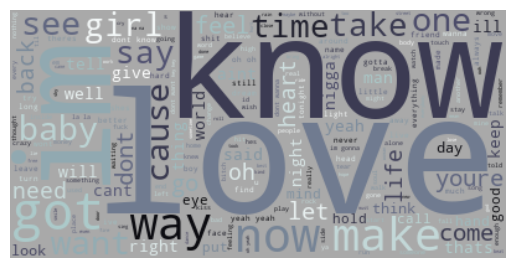

<Figure size 1000x1000 with 0 Axes>

In [6]:
Words=[]
for l in df['lyrics']:
    Words.append(re.split(r' ', l))
Words=flatten(Words)

wordcloud = WordCloud( background_color="#A9A9A9",colormap="bone").generate((" ").join(Words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(10,10))
plt.show()

Najczęsciej występujące słowa z usunięciem obecnie najczęściej pojawiających się słów "i", "you":

In [7]:
Words_2=[x for x in Words if x != "i" and x!='you' and x!='\n']
Words_freq_2=Counter(Words_2)
print("Najpopularniejsze słowa w całym zbiorze z wyłączeniem 'i' oraz 'you': ", Counter(Words_freq_2).most_common(10) )

Najpopularniejsze słowa w całym zbiorze z wyłączeniem 'i' oraz 'you':  [('the', 48506), ('to', 31158), ('and', 30736), ('a', 28383), ('me', 26692), ('my', 21392), ('it', 20561), ('in', 17267), ('im', 15175), ('on', 15049)]


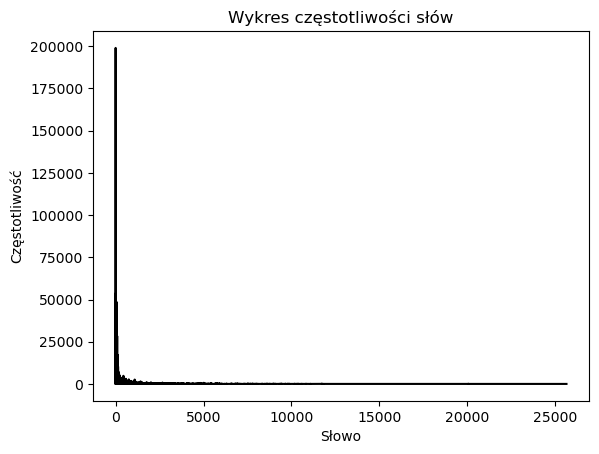

In [8]:
data = []
len_Words = len(set(Words))
Words_freq=Counter(Words)
data.append(go.Scatter(x = np.linspace(1, len_Words, len_Words), y = [frequency for frequency in Words_freq.values()]))
plt.plot(np.linspace(1, len_Words, len_Words), [frequency for frequency in Words_freq.values()], color='black')
plt.title(f'Wykres częstotliwości słów')
plt.xlabel('Słowo')
plt.ylabel('Częstotliwość')
plt.show()

Celem modelu jest stworzenie generatora w oparciu o różne gatunki muzyczne. W tym celu dataset zostanie podzielony na 6 podsetów i powstanie 6 modeli.

Stworzenie dataframe dla każdeog gatunku muzycznego:


In [9]:
dfs=[]
for genre in genres:
    globals()[f'df_{genre}'] = df[df[genre] =='yes']
    #wylistowanie zbiorów danych w podziale na gatunki
    dfs.append(globals()[f'df_{genre}'])
    
for j in range(len(genres)):  
  globals()[f'df_{genres[j]}'].to_excel(f'df_{genres[j]}.xlsx')


Liczba piosenek w podziale na gatunki:

In [10]:
for genre in genres:
  print(genre, globals()[f'df_{genre}'].shape[0])

pop 3918
rock 3318
jazz 105
rap 1080
country 1182
blues 304


Ustawienie parametrów do modelowania:

In [11]:
min_appearance= 7
seq_len = 5

Generowanie podstawowych informacji o zbiorze danych w podziale na gatunki, definiowanie modeli:

Informacje o zbiorze danych w podziale na gatunki:

pop :
Unikalne słowa:  18662
Wszystkie słowa:  825626
Najpopularniejsze słowa:  [('you', 33468), ('i', 31817), ('the', 26444), ('to', 17291), ('me', 16710), ('and', 16567), ('a', 15012), ('my', 12432), ('it', 11905), ('im', 9503)]
Liczba sekwencji o długości  5 :  825621
Liczba oryginalnych słów z mniejszą liczbą niż  7  wystąpień:  13810
Liczba oryginalnych słów z więksża liczbą niż  7  wystąpień:  4852 



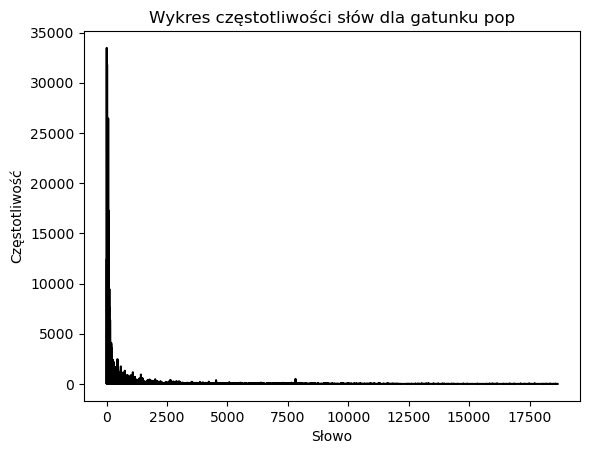

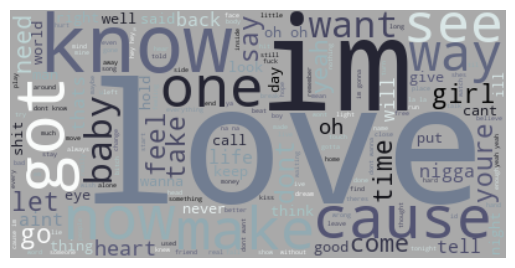

<Figure size 1000x1000 with 0 Axes>




rock :
Unikalne słowa:  12763
Wszystkie słowa:  510860
Najpopularniejsze słowa:  [('you', 18945), ('the', 18413), ('i', 18291), ('to', 12170), ('and', 11768), ('a', 11036), ('me', 8961), ('my', 6876), ('it', 6561), ('in', 6443)]
Liczba sekwencji o długości  5 :  510855
Liczba oryginalnych słów z mniejszą liczbą niż  7  wystąpień:  9412
Liczba oryginalnych słów z więksża liczbą niż  7  wystąpień:  3351 



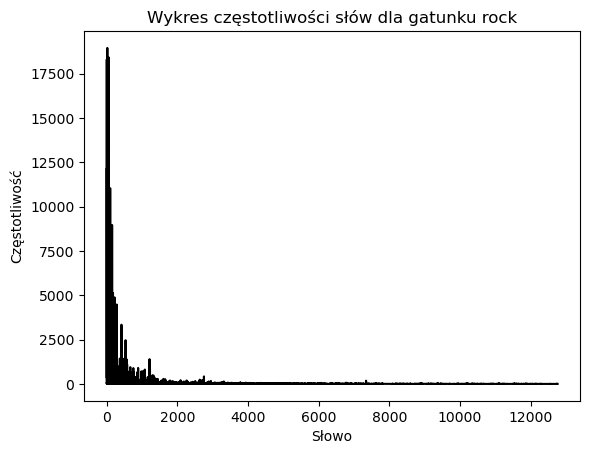

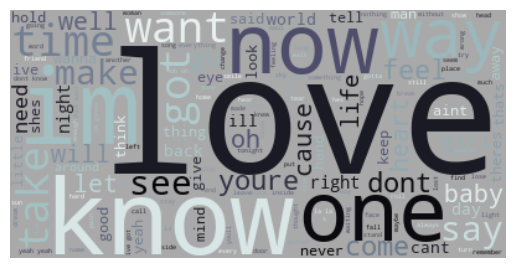

<Figure size 1000x1000 with 0 Axes>




jazz :
Unikalne słowa:  1891
Wszystkie słowa:  15949
Najpopularniejsze słowa:  [('i', 594), ('you', 571), ('the', 536), ('to', 358), ('me', 343), ('and', 323), ('a', 318), ('love', 250), ('my', 237), ('in', 222)]
Liczba sekwencji o długości  5 :  15944
Liczba oryginalnych słów z mniejszą liczbą niż  7  wystąpień:  1537
Liczba oryginalnych słów z więksża liczbą niż  7  wystąpień:  354 



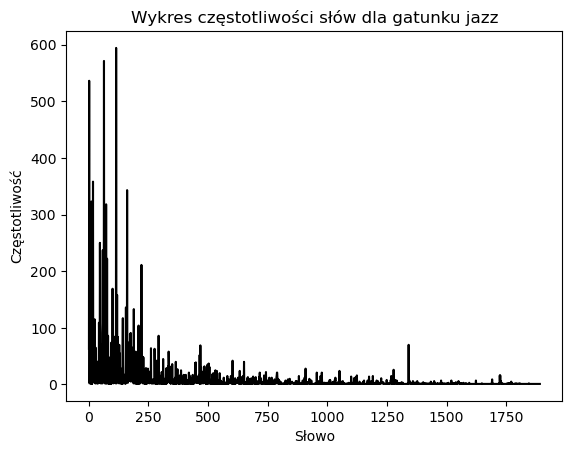

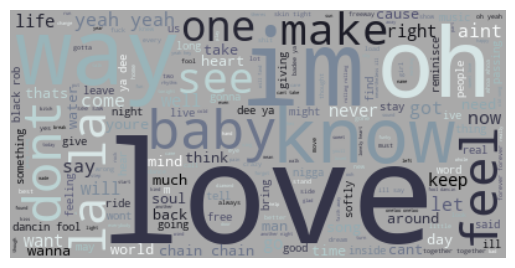

<Figure size 1000x1000 with 0 Axes>




rap :
Unikalne słowa:  15221
Wszystkie słowa:  345111
Najpopularniejsze słowa:  [('i', 13670), ('the', 11705), ('you', 11089), ('a', 6912), ('to', 6228), ('and', 6071), ('me', 6040), ('my', 5726), ('it', 5008), ('im', 4201)]
Liczba sekwencji o długości  5 :  345106
Liczba oryginalnych słów z mniejszą liczbą niż  7  wystąpień:  12053
Liczba oryginalnych słów z więksża liczbą niż  7  wystąpień:  3168 



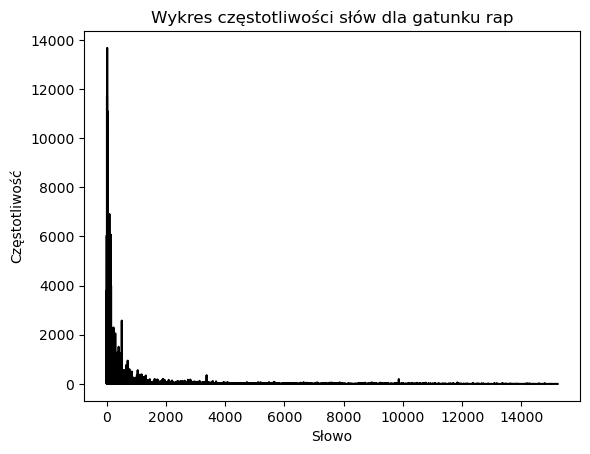

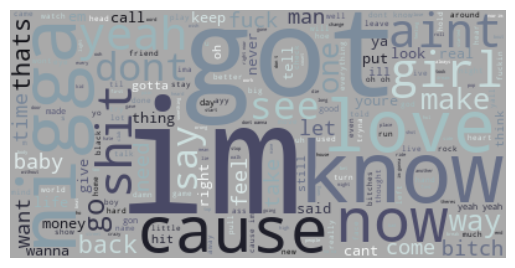

<Figure size 1000x1000 with 0 Axes>




country :
Unikalne słowa:  6959
Wszystkie słowa:  202596
Najpopularniejsze słowa:  [('the', 7164), ('i', 6839), ('you', 6588), ('and', 5316), ('a', 5186), ('to', 4284), ('me', 3020), ('in', 2916), ('it', 2795), ('my', 2586)]
Liczba sekwencji o długości  5 :  202591
Liczba oryginalnych słów z mniejszą liczbą niż  7  wystąpień:  4985
Liczba oryginalnych słów z więksża liczbą niż  7  wystąpień:  1974 



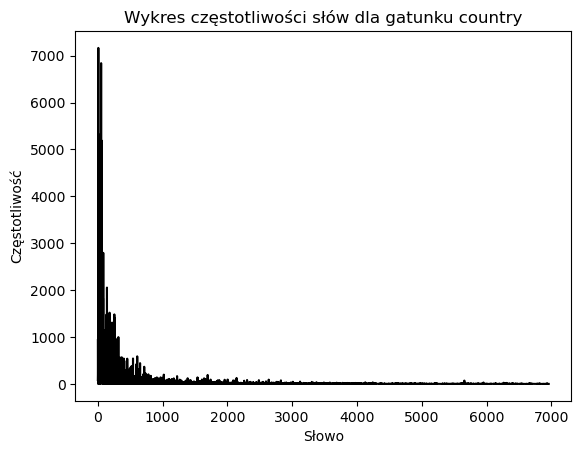

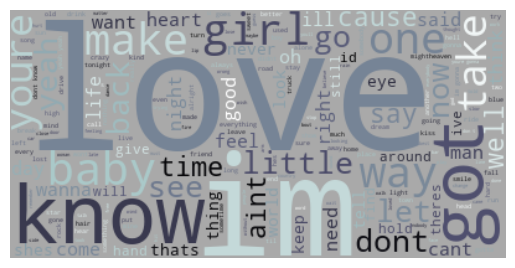

<Figure size 1000x1000 with 0 Axes>




blues :
Unikalne słowa:  3184
Wszystkie słowa:  42970
Najpopularniejsze słowa:  [('you', 1590), ('i', 1554), ('the', 1512), ('to', 1157), ('and', 921), ('a', 847), ('me', 837), ('it', 582), ('my', 581), ('love', 565)]
Liczba sekwencji o długości  5 :  42965
Liczba oryginalnych słów z mniejszą liczbą niż  7  wystąpień:  2496
Liczba oryginalnych słów z więksża liczbą niż  7  wystąpień:  688 



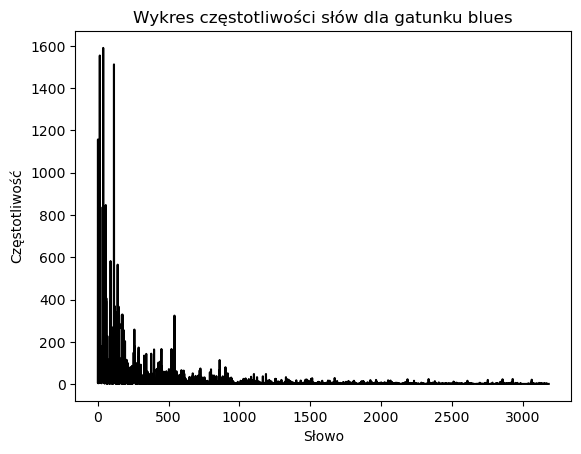

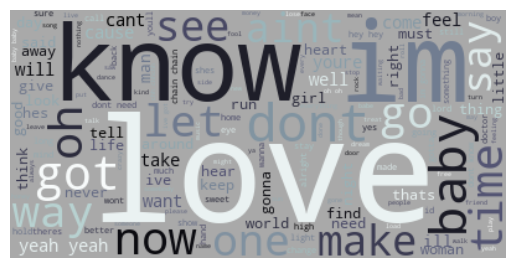

<Figure size 1000x1000 with 0 Axes>

In [12]:
print('Informacje o zbiorze danych w podziale na gatunki:\n')
for j in range(len(genres)):

  Words=[]
  unpopular_words=set()
  popular_words=set()

  #Stworzenie listy słów:
  print(genres[j], ':')
  for l in dfs[j]['lyrics']:
    Words.append(re.split(r' ', l))
  Words=flatten(Words)
  Words=[x for x in Words if x]
  Words = [i for i in Words if i != '\n']

  Words_freq=Counter(Words)
  len_Words = len(set(Words))
  
  print("Unikalne słowa: ", len_Words)
  print("Wszystkie słowa: ", len(Words))
  print("Najpopularniejsze słowa: ", Counter(Words).most_common(10) )

  sequences = []
  for i in range(len(Words) - seq_len ):
    sequences.append(Words[i: i + seq_len])
  print('Liczba sekwencji o długości ',seq_len,': ',len(sequences))

  Words_freq=Counter(Words)
  for key in Words_freq.keys():
    if Words_freq[key] < min_appearance:
      unpopular_words.add(key)
    else:
      popular_words.add(key)    
  print('Liczba oryginalnych słów z mniejszą liczbą niż ', min_appearance, ' wystąpień: ', len(unpopular_words))
  print('Liczba oryginalnych słów z więksża liczbą niż ', min_appearance, ' wystąpień: ', len(popular_words), '\n')
    
  data = []
  data.append(go.Scatter(x = np.linspace(1, len_Words, len_Words), y = [frequency for frequency in Words_freq.values()]))
  plt.plot(np.linspace(1, len_Words, len_Words), [frequency for frequency in Words_freq.values()], color='black')
  plt.title(f'Wykres częstotliwości słów dla gatunku {genres[j]}')
  plt.xlabel('Słowo')
  plt.ylabel('Częstotliwość')
  plt.show()

  print('\n')
  wordcloud = WordCloud( background_color="#A9A9A9",colormap="bone").generate((" ").join(Words))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.figure(figsize=(10,10))
  plt.show()

  print('\n\n')
